This notebook will be used to create the violin plots for fig 2 of the paper. These violin plots will show the distribution of the different feature values calculated for the set of experiments that has been tierpsied 

# Import the libraries

In [1]:
import os
import sys


import h5py
import numpy as np
import pandas as pd

In [2]:
import tqdm
from itertools import compress

In [3]:
from scipy import stats

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from joblib import Parallel, delayed

# Get the data

In [6]:
path_metadata = '/data/longterm/10/athira/paper_tierpsy_behavior_v0/metadata/20210209_metadata_1743_of_4086_exps.pickle'

In [7]:
df_metadata = pd.read_pickle(path_metadata)

In [8]:
df_drugs_and_wild = df_metadata[(df_metadata['good_694'] == True) | (df_metadata['drugs_899'] == True)]

In [9]:
# This should be 1593 
len(df_drugs_and_wild.index)

1593

In [10]:
df_features = pd.read_pickle('/data/longterm/10/athira/July17_features_combined_noLightStimuli.pickle')

In [11]:
df_features.reset_index(drop=True, inplace=True)
df_features

,frames,filename,drug,light,curv_head,speed_x_head,speed_y_head,speed_head,tan_head,angvel_head,...,rel_tan_tail_mid,rel_tan_tail_post_mid,rel_tan_tail_tip,ects_1,ects_2,ects_3,ects_4,ects_5,ects_6,quirkness
0,7,20180919_115015_1_5m0s_None_None_None_INVERTED...,None,None,-0.017198,-27.008057,-0.536011,27.013375,1.728838,-1.680707,...,-0.965574,-1.442325,4.191924,-0.242226,0.252907,0.100737,-0.103630,-0.036702,0.040370,0.942960
1,8,20180919_115015_1_5m0s_None_None_None_INVERTED...,None,None,-0.022632,-25.689758,-1.873779,25.758003,0.048131,-1.680707,...,0.737270,0.893605,0.906057,0.171081,0.179248,-0.096917,0.017548,0.020535,-0.006624,0.980586
2,9,20180919_115015_1_5m0s_None_None_None_INVERTED...,None,None,-0.013683,0.178772,12.000000,12.001332,5.897407,5.849276,...,0.261397,-5.556279,-4.919775,0.135002,-0.094772,-0.126590,0.110299,0.006492,0.022628,0.971257
3,20,20180919_115015_1_5m0s_None_None_None_INVERTED...,None,None,-0.016047,-5.867770,-1.454545,6.045364,0.244842,-0.513870,...,5.793753,5.687008,5.740084,-0.072909,-0.066518,0.017333,0.002223,-0.083971,0.042877,0.992129
4,23,20180919_115015_1_5m0s_None_None_None_INVERTED...,None,None,0.005098,-4.011912,0.333333,4.025736,6.239577,1.998245,...,-5.994454,-6.180219,-0.169155,0.020776,0.112950,-0.028227,0.071771,0.060161,-0.024482,0.998460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18013993,8996,20180808_112130_1_5m0s_Dopamine_None_None_skel...,Dopamine,None,0.003221,1.000000,-0.320496,1.050104,4.798446,-0.000824,...,-0.887769,-1.041476,-1.033917,-0.098597,-0.030548,-0.014418,-0.033454,0.025632,0.009221,0.970947
18013994,8997,20180808_112130_1_5m0s_Dopamine_None_None_skel...,Dopamine,None,0.005596,0.000000,0.047180,0.047180,4.765812,-0.032634,...,-0.788512,-0.950782,-1.077892,-0.101701,-0.016822,0.003646,-0.022406,0.032891,0.016292,0.968614
18013995,8998,20180808_112130_1_5m0s_Dopamine_None_None_skel...,Dopamine,None,0.003030,-0.669434,0.529572,0.853573,4.788003,0.022191,...,-0.810796,-1.024025,-1.074564,-0.099125,-0.022143,-0.006314,-0.039338,0.031269,0.008395,0.971154
18013996,8999,20180808_112130_1_5m0s_Dopamine_None_None_skel...,Dopamine,None,-0.007859,1.000000,0.545929,1.139315,4.793839,0.005836,...,-0.866849,-1.047440,-1.126085,-0.095032,0.007813,-0.011771,-0.047995,0.043870,0.013303,0.967644


In [12]:
params_list = df_features.columns.to_list()

In [13]:
speed_xys = ['speed_x_head', 'speed_y_head','speed_x_neck', 'speed_y_neck','speed_x_tail_base', 'speed_y_tail_base',
 'speed_x_tail_pre_mid', 'speed_y_tail_pre_mid','speed_x_tail_mid', 'speed_y_tail_mid',
 'speed_x_tail_post_mid', 'speed_y_tail_post_mid','speed_x_tail_tip', 'speed_y_tail_tip']
for sp_ in speed_xys:
    params_list.remove(sp_)

In [14]:

params_list.remove('frames')
params_list.remove('filename')
params_list.remove('drug')
params_list.remove('light')
print(params_list)

['curv_head', 'speed_head', 'tan_head', 'angvel_head', 'curv_neck', 'speed_neck', 'tan_neck', 'angvel_neck', 'curv_tail_base', 'speed_tail_base', 'tan_tail_base', 'angvel_tail_base', 'curv_tail_pre_mid', 'speed_tail_pre_mid', 'tan_tail_pre_mid', 'angvel_tail_pre_mid', 'curv_tail_mid', 'speed_tail_mid', 'tan_tail_mid', 'angvel_tail_mid', 'curv_tail_post_mid', 'speed_tail_post_mid', 'tan_tail_post_mid', 'angvel_tail_post_mid', 'curv_tail_tip', 'speed_tail_tip', 'tan_tail_tip', 'angvel_tail_tip', 'rel_tan_neck', 'rel_tan_tail_base', 'rel_tan_tail_pre_mid', 'rel_tan_tail_mid', 'rel_tan_tail_post_mid', 'rel_tan_tail_tip', 'ects_1', 'ects_2', 'ects_3', 'ects_4', 'ects_5', 'ects_6', 'quirkness']


In [15]:
params_list

['curv_head',
 'speed_head',
 'tan_head',
 'angvel_head',
 'curv_neck',
 'speed_neck',
 'tan_neck',
 'angvel_neck',
 'curv_tail_base',
 'speed_tail_base',
 'tan_tail_base',
 'angvel_tail_base',
 'curv_tail_pre_mid',
 'speed_tail_pre_mid',
 'tan_tail_pre_mid',
 'angvel_tail_pre_mid',
 'curv_tail_mid',
 'speed_tail_mid',
 'tan_tail_mid',
 'angvel_tail_mid',
 'curv_tail_post_mid',
 'speed_tail_post_mid',
 'tan_tail_post_mid',
 'angvel_tail_post_mid',
 'curv_tail_tip',
 'speed_tail_tip',
 'tan_tail_tip',
 'angvel_tail_tip',
 'rel_tan_neck',
 'rel_tan_tail_base',
 'rel_tan_tail_pre_mid',
 'rel_tan_tail_mid',
 'rel_tan_tail_post_mid',
 'rel_tan_tail_tip',
 'ects_1',
 'ects_2',
 'ects_3',
 'ects_4',
 'ects_5',
 'ects_6',
 'quirkness']

# Make plots for control 

In [16]:
df_features_combined = pd.merge(df_features, df_metadata[['filename','good_694', 'drugs_899']], left_on=['filename'], right_on=['filename'],
        left_index=True, how='left' )


In [ ]:
df_features_control = df_features_combined[df_features_combined['good_694'] == True] 

In [ ]:
len(df_features_control.index)

In [ ]:
len(df_features_control.filename.unique())

In [ ]:
df_features_control.columns

In [ ]:
feat = 'curv'
df_feat_control = df_features_control.filter(like=f'{feat}_')
df_feat_control_zf = df_features_control[(np.abs(stats.zscore(df_feat_control)) < 3).all(axis=1)] 
df_feat_control_zf = df_feat_control_zf.filter(items = ["drug",f"{feat}_neck",f"{feat}_tail_base", f"{feat}_tail_pre_mid",
                                            f"{feat}_tail_mid", f"{feat}_tail_post_mid", f"{feat}_tail_tip"])

In [ ]:
df_feat_control

In [ ]:
curv_unit_conv =  (1/11.56)

In [ ]:
curv_unit_conv

In [ ]:
df_feat_control = df_feat_control * curv_unit_conv 

In [ ]:
df_feat_control 

In [ ]:
# Try to get some stats for control 

import itertools 
from ipywidgets import widgets



In [ ]:
@widgets.interact_manual
def get_pvals_shapiro(feat = ['curv', 'speed', 'rel_tan']):

    df_feat_control = df_features_control.filter(like=f'{feat}_')
    cols = df_feat_control.columns
    
    

    for i in cols:


        test_results = stats.shapiro(df_feat_control[i])
        print(test_results)
    

In [ ]:
@widgets.interact_manual
def get_pvals_wilcoxon(feat = ['curv', 'speed', 'rel_tan', 'ects'], tail_ = ['two-sided', 'greater', 'less']):

    df_feat_control = df_features_control.filter(like=f'{feat}_')
    cols = df_feat_control.columns
    df_pvals_curv_control = pd.DataFrame(columns=cols, index=cols)
    df_teststat_curv_control = pd.DataFrame(columns=cols, index=cols)
    

    for i in itertools.permutations(cols, 2):

        rvs1 = df_feat_control[i[0]]
        rvs2 = df_feat_control[i[1]]
        test_results = stats.wilcoxon(rvs1, rvs2, alternative=tail_)

        test_pval = test_results[1]
        test_stat = test_results[0]
        df_pvals_curv_control.at[i[0],i[1]] = test_pval
        df_teststat_curv_control.at[i[0],i[1]] = test_stat
        
        
#     writer_1 = pd.ExcelWriter(f'./Results_30072021/pvals_wilcoxon_control/pvals_control_fig1_{feat}_{tail_}.xlsx', engine='openpyxl')

#     # Write each dataframe to a different worksheet.

#     df_pvals_curv_control.to_excel(writer_1, sheet_name=f'pvalue_{tail_}')
#     df_teststat_curv_control.to_excel(writer_1, sheet_name=f'test statistic_{tail_}')

#     # Close the Pandas Excel writer and output the Excel file.
#     writer_1.save()
        
    return True
    

In [ ]:
df_melted = pd.melt(df_feat_control_zf, var_name= 'segment', value_name=feat)

In [ ]:
df_melted

In [ ]:
# with sns.axes_style("darkgrid"):
#     ax = sns.violinplot(data = df_melted, x = 'segment', y= feat, color='b')
#     ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [17]:
feat_names_dict = {'curv':'Curvature', 'speed': 'Speed', 'rel_tan': 'Relative tangent angles'}

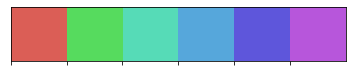

In [18]:
cpal = sns.color_palette("hls",9)
color_pal = [cpal[0], cpal[3], cpal[4], cpal[5], cpal[6], cpal[7]]
# color_pal_dict = {'neck':cpal[0], 'tail_base':cpal[3], 'tail_pre_mid':cpal[4], 'tail_mid':cpal[5], 'tail_post_mid':cpal[6], 'tail_tip':cpal[7]}

sns.palplot(color_pal)

In [19]:
corn_b = sns.color_palette("tab10",9)[0]

In [20]:
df_control_zf_dict = {}

In [21]:
feat_short_dict = {'curv':'c', 'speed':'s', 'rel_tan':'rta', 'ects':'EC' }

In [ ]:
# fig, axes = plt.subplots(1,3, figsize = (24, 10))

for i, feat in tqdm.tqdm(enumerate(['curv', 'speed', 'rel_tan'])):
    
    feat_s = feat_short_dict[feat]
    
    df_feat_control = df_features_control.filter(items = [f"{feat}_neck",f"{feat}_tail_base", f"{feat}_tail_pre_mid",
                                                f"{feat}_tail_mid", f"{feat}_tail_post_mid", f"{feat}_tail_tip"])
    df_feat_control_zf = df_features_control[(np.abs(stats.zscore(df_feat_control)) < 3).all(axis=1)] 
    df_feat_control_zf = df_feat_control_zf.filter(items = [f"{feat}_neck",f"{feat}_tail_base", f"{feat}_tail_pre_mid",
                                                f"{feat}_tail_mid", f"{feat}_tail_post_mid", f"{feat}_tail_tip"])

    col_rename_dict = {f"{feat}_neck" : f"{feat_s}N",
                       f"{feat}_tail_base" :f"{feat_s}TB", 
                       f"{feat}_tail_pre_mid" : f"{feat_s}TprM",      
                       f"{feat}_tail_mid": f"{feat_s}TM", 
                       f"{feat}_tail_post_mid": f"{feat_s}TpoM", 
                       f"{feat}_tail_tip": f"{feat_s}TT"}
    

        
    df_feat_control_zf.rename(columns= col_rename_dict, inplace=True)
    df_control_zf_dict[feat] = df_feat_control_zf

In [ ]:
#     df_melted = pd.melt(df_feat_control_zf, var_name= 'segment', value_name= feat)
fig, axes = plt.subplots(1,3, figsize = (24, 10))
for i, feat in tqdm.tqdm(enumerate(['curv', 'speed', 'rel_tan'])):
    
    df_feat_control_zf = df_control_zf_dict[feat]
    if feat == 'curv':
        df_feat_control_zf = df_feat_control_zf * (1/11.56)
    elif feat == 'speed':
        df_feat_control_zf = df_feat_control_zf * (346.80)
    sns.violinplot(data = df_feat_control_zf, ax=axes[i], palette= color_pal, alpha = 0.1)
    axes[i].set_xticklabels(axes[i].get_xticklabels(),rotation=30, size = 'x-large')
    axes[i].set_ylabel(feat_names_dict[feat], size = 'xx-large')
    plt.setp(axes[i].collections, alpha=.5)

In [ ]:
# for ax in axes:
#     plt.setp(ax.collections, alpha=.5)

In [22]:
dest_folder_oct18 = '/data/temp/athira/oct18_violinplots_rescaled'

In [ ]:
fig.savefig(os.path.join(dest_folder_oct18, 'stats_control_feats3_a.svg'))

In [ ]:
df_feat_control = df_features_control.filter(like='ects_')
df_feat_control_zf = df_features_control[(np.abs(stats.zscore(df_feat_control)) < 3).all(axis=1)] 
df_feat_control_zf = df_feat_control_zf.filter(like='ects_')


df_melted = pd.melt(df_feat_control_zf, var_name= 'coeff', value_name= 'ects')
# with sns.axes_style("darkgrid"):



In [ ]:

# df_feat_control = df_features_control.filter(like='ects_')
# df_feat_control_zf = df_features_control[(np.abs(stats.zscore(df_feat_control)) < 3).all(axis=1)] 
# df_feat_control_zf = df_feat_control_zf.filter(like='ects_')

# df_melted = pd.melt(df_feat_control_zf, var_name= 'coeff', value_name= 'ects')
# # with sns.axes_style("darkgrid"):
fig2, ax2 = plt.subplots(1,1, figsize = (15, 10))
sns.violinplot(data = df_melted, x = 'coeff', y= 'ects', ax=ax2, palette=sns.color_palette('Set2',6))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30, size = 'x-large')
ax2.set_ylabel('Eigen cofficient value', size = 'xx-large')
ax2.set_xlabel('Coefficient', size = 'xx-large')
plt.setp(ax2.collections, alpha=.8)
fig2.savefig(os.path.join(dest_folder_oct18, 'stats_control_feats3_a.svg'))

In [ ]:
plt.setp(ax2.collections)
fig.savefig('stats_control_feats3_b.svg')

In [ ]:
df_feat_control = df_features_control.filter(like='quirkness')
df_feat_control_zf = df_features_control[(np.abs(stats.zscore(df_feat_control)) < 3).all(axis=1)] 
df_feat_control_zf = df_feat_control_zf.filter(like='quirkness')

with sns.axes_style("darkgrid"):
    fig, ax3 = plt.subplots(1,1, figsize = (8, 10))
    sns.violinplot(data = df_feat_control_zf, color= corn_b, alpha = 0.5, ax = ax3 )
    ax3.set_xticklabels(ax3.get_xticklabels(),rotation=30)
    ax3.set_ylabel('Quirkiness', size = 'xx-large')
    ax3.axes.xaxis.set_visible(False)
# fig.savefig('stats_control_feats1_c.svg')

# Statistic tests

In [ ]:
from scipy.stats import mannwhitneyu

In [23]:
def test_drugs_mannwhitney(drug, params_list, _tail):
    
    pvalues_dict = {}
    pvalues_dict['drug'] = drug
    
    if drug == 'Dopamine':
        control = 'AA'
    else:
        control = 'None'
    
    for param in params_list:
        
        results = mannwhitneyu(*[df_features_drugs_and_control[param][df_features_drugs_and_control["drug"] == group].values 
                         for group in [control,drug]], alternative= _tail)
        
        pvalues_dict[param] = results[-1]
        
        
    return pvalues_dict

In [24]:
drugs_list = list(df_drugs_and_wild.drug.unique())
# drugs_list.remove('AA')
drugs_list.remove('None')
drugs_list.remove('Tyramine')
drugs_list.remove('Octopamine')
drugs_list.remove('Quinpirole0003')
drugs_list


['Chlorpromazine',
 'Methiothepin',
 'Dopamine',
 'Raclopride',
 'AA',
 'Paroxetine',
 'Phentolamine',
 'Serotonin',
 'Fluoxetine',
 'Clomipramine',
 'Alphamethyl',
 'Quinpirole003',
 'Imipramine',
 'Mianserin']

In [25]:
len(drugs_list)

14

In [26]:
df_features_drugs_and_control = df_features_combined[(df_features_combined['good_694'] == True) | (df_features_combined['drugs_899'] == True)] 

In [ ]:
mannwhitney_combo_list = Parallel(n_jobs=len(drugs_list), verbose = 5)(delayed(test_drugs_mannwhitney)(drug, params_list,'two-sided') 
                                                          for drug in drugs_list)

In [ ]:
df_pval_mannwhitney = pd.DataFrame(mannwhitney_combo_list)

In [ ]:
df_pval_mannwhitney.set_index('drug', inplace = True)

In [ ]:
df_pval_mannwhitney.index

In [ ]:

# Bonferroni correction
bf_corr_pvalue = 0.05/len(df_pval_mannwhitney.index) 
df_binary_bf = df_pval_mannwhitney > bf_corr_pvalue



In [ ]:
mwu_combo_list_less = Parallel(n_jobs=15, verbose = 5)(delayed(test_drugs_mannwhitney)(drug, params_list, 'less') 
                                                          for drug in drugs_list)

df_pval_mwu_less = pd.DataFrame(mwu_combo_list_less)
df_pval_mwu_less.set_index('drug', inplace = True)
df_binary_bf_less = df_pval_mwu_less > bf_corr_pvalue

In [ ]:
mwu_combo_list_greater = Parallel(n_jobs=15, verbose = 5)(delayed(test_drugs_mannwhitney)(drug, params_list, 'greater') 
                                                          for drug in drugs_list)
df_pval_mwu_greater = pd.DataFrame(mwu_combo_list_greater)
df_pval_mwu_greater.set_index('drug', inplace = True)
df_binary_bf_greater = df_pval_mwu_greater > bf_corr_pvalue

In [ ]:
df_pval_mannwhitney.to_pickle('./Results_30072021/drugs_pvals_all_for_figures/mwu_pval_drugs_twosided.pickle')
df_pval_mwu_less.to_pickle('./Results_30072021/drugs_pvals_all_for_figures/mwu_pval_drugs_less.pickle')
df_pval_mwu_greater.to_pickle('./Results_30072021/drugs_pvals_all_for_figures/mwu_pval_drugs_greater.pickle')

In [ ]:
df_pval_mannwhitney.to_pickle('./Results_30072021/drugs_pvals_all_for_figures/mwu_pval_drugs_twosided.pickle')
df_pval_mwu_less.to_pickle('./Results_30072021/drugs_pvals_all_for_figures/mwu_pval_drugs_less.pickle')
df_pval_mwu_greater.to_pickle('./Results_30072021/drugs_pvals_all_for_figures/mwu_pval_drugs_greater.pickle')

In [ ]:
writer = pd.ExcelWriter('./Results_30072021/drugs_pvals_all_for_figures/pvalues_mannwhitneyu_drugs_all_for_figures.xlsx', engine='openpyxl')

# Write each dataframe to a different worksheet.
df_pval_mannwhitney.to_excel(writer, sheet_name='Two_tailed')
df_pval_mwu_less.to_excel(writer, sheet_name='Less')
df_pval_mwu_greater.to_excel(writer, sheet_name='Greater')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [ ]:
# df_binary_bf.to_pickle('./Results_30072021/drugs_pvals_all_for_figures/mwu_test_drugs_twosided.pickle')
# df_binary_bf_less.to_pickle('./Results_30072021/drugs_pvals_all_for_figures/mwu_test_drugs_less.pickle')
# df_binary_bf_greater.to_pickle('./Results_30072021/drugs_pvals_all_for_figures/mwu_test_drugs_greater.pickle')

In [27]:
df_binary_bf = pd.read_pickle('./Results_30072021/drugs_pvals_all_for_figures/mwu_test_drugs_twosided.pickle')
df_binary_bf_less = pd.read_pickle('./Results_30072021/drugs_pvals_all_for_figures/mwu_test_drugs_less.pickle')
df_binary_bf_greater = pd.read_pickle('./Results_30072021/drugs_pvals_all_for_figures/mwu_test_drugs_greater.pickle')

# Make plots

## test for one parameter/ feature

In [ ]:
param = 'curv_tail_base'
list_drugs_l = df_binary_bf.index[(~df_binary_bf[param]==True)&
                                 (~df_binary_bf_less[param]==True)&
                                 (~df_binary_bf_greater[param]==False)].values
list_drugs_g = df_binary_bf.index[(~df_binary_bf[param]==True)&
                                 (~df_binary_bf_greater[param]==True)&
                                 (~df_binary_bf_less[param]==False)].values
list_drugs_lg = df_binary_bf.index[(~df_binary_bf[param]==True)&
                                 (~df_binary_bf_greater[param]==True)&
                                 (~df_binary_bf_less[param]==True)].values

In [ ]:
list_drugs_l

In [ ]:
list_drugs_g

In [ ]:
list_drugs_lg

In [28]:
def get_zscores(param):

    df_param = df_features_drugs_and_control.groupby('drug')[param].transform(lambda x: np.abs(stats.zscore(x, ddof=1)))
    
    return df_param

In [29]:
short_params_list =  ['curv_neck',
'speed_neck',
'curv_tail_base',
'speed_tail_base',
'curv_tail_pre_mid',
'speed_tail_pre_mid',
'curv_tail_mid',
'speed_tail_mid',
'curv_tail_post_mid',
'speed_tail_post_mid',
'curv_tail_tip',
'speed_tail_tip',
'rel_tan_neck',
'rel_tan_tail_base',
'rel_tan_tail_pre_mid',
'rel_tan_tail_mid',
'rel_tan_tail_post_mid',
'rel_tan_tail_tip',
'ects_1',
'ects_2',
'ects_3',
'ects_4',
'ects_5',
'ects_6',
'quirkness']

In [30]:
df_params_list = Parallel(n_jobs=25, verbose = 5)(delayed(get_zscores)(param) for param in short_params_list)

df_combined_zscores = pd.concat(df_params_list, axis = 1, keys=[f'{df.name}_zscore' for df in df_params_list])
df_combined_zscores

[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   6 out of  25 | elapsed:   21.2s remaining:  1.1min
[Parallel(n_jobs=25)]: Done  12 out of  25 | elapsed:   30.5s remaining:   33.1s
[Parallel(n_jobs=25)]: Done  18 out of  25 | elapsed:   41.4s remaining:   16.1s
[Parallel(n_jobs=25)]: Done  25 out of  25 | elapsed:   53.9s finished


,curv_neck_zscore,speed_neck_zscore,curv_tail_base_zscore,speed_tail_base_zscore,curv_tail_pre_mid_zscore,speed_tail_pre_mid_zscore,curv_tail_mid_zscore,speed_tail_mid_zscore,curv_tail_post_mid_zscore,speed_tail_post_mid_zscore,...,rel_tan_tail_mid_zscore,rel_tan_tail_post_mid_zscore,rel_tan_tail_tip_zscore,ects_1_zscore,ects_2_zscore,ects_3_zscore,ects_4_zscore,ects_5_zscore,ects_6_zscore,quirkness_zscore
0,0.806790,5.529372,0.036567,4.937554,2.945483,4.301404,4.221243,4.586266,2.956435,4.312869,...,0.544205,0.749815,2.226712,2.895174,3.365822,1.448431,2.484689,0.960742,1.112145,0.744641
0,1.338447,5.761069,2.117753,4.821584,1.892472,4.382247,1.403737,4.458927,0.057270,4.011417,...,0.500619,0.537594,0.519983,1.862154,2.413042,1.804495,0.224129,0.512647,0.329381,0.013380
0,0.628036,1.842266,0.038801,0.285821,0.476083,0.154675,1.955609,1.508867,2.786050,2.826136,...,0.208635,3.017151,2.506041,1.446874,1.131399,2.292855,2.297473,0.151159,0.567905,0.174563
0,0.320115,1.258930,0.886801,0.951114,1.233068,0.639000,0.604067,0.645673,0.723639,0.717548,...,3.603157,3.179398,3.030850,0.946264,0.765928,0.075786,0.118463,2.177526,1.189065,0.245925
0,0.026918,1.076364,0.235692,1.033256,1.532862,0.787046,0.849712,0.840958,0.840831,0.995012,...,3.629807,3.361025,0.038498,0.132082,1.555486,0.674013,1.436230,1.532691,0.877158,0.373472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081,0.483894,0.257404,0.746125,0.211023,1.814834,0.001385,0.925915,0.055652,0.253625,0.084765,...,0.667336,0.706976,0.700128,1.190182,0.544266,0.553741,1.030347,0.743452,0.287035,0.380663
4081,0.455737,0.318403,0.405858,0.311149,1.685597,0.292693,1.306242,0.313435,0.429103,0.296438,...,0.601976,0.656294,0.723353,1.233858,0.291034,0.225110,0.756626,0.960144,0.584201,0.445584
4081,0.555040,0.049089,0.870691,0.145036,1.551647,0.253130,1.293855,0.179866,0.214230,0.196723,...,0.616650,0.697224,0.721595,1.197610,0.389212,0.406306,1.176133,0.911732,0.252293,0.374909
4081,0.624257,0.420533,1.131014,0.230570,1.798349,0.236096,1.000399,0.260473,0.104712,0.334747,...,0.653560,0.710308,0.748806,1.140012,0.163450,0.505593,1.390640,1.287896,0.458584,0.472598


In [31]:
# df_combined_zscores = pd.concat(df_params_list, axis = 1, keys=[f'{df.name}_zscore' for df in df_params_list])
# df_combined_zscores

In [32]:
df_features_zscores = pd.concat([df_features_drugs_and_control,df_combined_zscores], axis=1)

In [34]:
drugs_list

['Chlorpromazine',
 'Methiothepin',
 'Dopamine',
 'Raclopride',
 'AA',
 'Paroxetine',
 'Phentolamine',
 'Serotonin',
 'Fluoxetine',
 'Clomipramine',
 'Alphamethyl',
 'Quinpirole003',
 'Imipramine',
 'Mianserin']

In [35]:
def make_a_melted_df(main_df, param, drug_list):
    
    list_to_melt = []
    params_df = main_df.filter(items=['drug', param, f'{param}_zscore'])
    
    for drug in drug_list:
        
        if drug == 'Dopamine':
            control = 'AA'
        else :
            control = 'None'
        
        # Select only those rows which are relevant to the particular drug 
        drug_df = params_df[(params_df['drug']==control)|(params_df['drug']==drug)]
        
        # Select those rows which have an acceptable zscore
        drug_df = drug_df[drug_df[f'{param}_zscore'] < 3]
        drug_df.drop(columns=f'{param}_zscore', inplace=True)
        
        # Append a column as drug_screened
        drug_df['test_drug'] = drug
        
        # Rename the drug column
        drug_df['drug']= drug_df.drug.apply(lambda x: 'drug' if x==drug else 'control')
        
        list_to_melt.append(drug_df)
    
    melted_param_df = pd.concat(list_to_melt)
    return melted_param_df      


In [ ]:
melted_curvtb_df = make_a_melted_df(df_features_zscores, 'curv_tail_base', drugs_list )

In [ ]:
melted_curvtb_df

In [ ]:
melted_curvtb_df.drug.unique()

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(25,10))
sns.violinplot(data=melted_curvtb_df, x='test_drug',y='curv_tail_base',hue='drug', 
                                   split=True, scale="width", scale_hue=False, ax=axes)

In [ ]:
melted_curvtb_df_g = make_a_melted_df(df_features_zscores, 'curv_tail_base', list_drugs_g)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(25,10))
sns.violinplot(data=melted_curvtb_df_g, x='test_drug',y='curv_tail_base',hue='drug', hue_order = ['control', 'drug'],
                                   split=True, scale="width", scale_hue=False, ax=axes)

In [ ]:
# def plot_fig2(param):
    
#     violin_height = 4
        
#     list_drugs = []
#     dict_drugs = {}

#     list_drugs1 = list(df_binary_bf.index[(~df_binary_bf[param]==True)&
#                                      (~df_binary_bf_less[param]==True)&
#                                      (~df_binary_bf_greater[param]==False)].values)
#     if list_drugs1:
#         list_drugs.append(list_drugs1)
#         dict_drugs['g'] = list_drugs1

#     list_drugs2 = list(df_binary_bf.index[(~df_binary_bf[param]==True)&
#                                      (~df_binary_bf_greater[param]==True)&
#                                      (~df_binary_bf_less[param]==False)].values)
#     if list_drugs2:
#         list_drugs.append(list_drugs2)
#         dict_drugs['l'] = list_drugs2

#     list_drugs3 = list(df_binary_bf.index[(~df_binary_bf[param]==True)&
#                                      (~df_binary_bf_greater[param]==True)&
#                                      (~df_binary_bf_less[param]==True)].values)
#     if list_drugs3:
#         list_drugs.append(list_drugs3)
#         dict_drugs['lg'] = list_drugs3

# #     n_drugs = len(list_drugs1) + len(list_drugs2) + len(list_drugs3)
# #         n_plots = (len(list_drugs1)!=0) + (len(list_drugs2)!=0) + (len(list_drugs3)!=0)

#     n_plots = len(list(dict_drugs.keys()))
#     if n_plots != 0:

#         for i, key in enumerate(dict_drugs.keys()):
            
#             ld = dict_drugs[key]
#             n_drugs = len(ld)
            
#             fig, axes = plt.subplots(1, 1, figsize=(violin_height*n_drugs/2, violin_height))
            
            
#             melted_param_df = make_a_melted_df(df_features_zscores, param, ld)
#             if 'speed_' in param: 
#                 sns.violinplot(data=melted_param_df, x='test_drug',y=param, hue='drug', hue_order = ['control', 'drug'],
#                                            split=True, scale="width", scale_hue=False, ax=axes, cut=0)
#             else:
#                 sns.violinplot(data=melted_param_df, x='test_drug',y=param, hue='drug', hue_order = ['control', 'drug'],
#                                        split=True, scale="width", scale_hue=False, ax=axes)
            
#             if key == 'l':
#                 title_string = 'Significantly less than control'
#             elif key == 'g':
#                 title_string = 'Significantly greater than control'
#             if key == 'lg':
#                 title_string = 'Two tailed significance'
            
#             axes.set_title(title_string, size = 'xx-large')
#             axes.set_xticklabels(axes.get_xticklabels(), size = 'x-large')
#             axes.set_ylabel(param, size = 'xx-large')
#             plt.tight_layout()
#             fig.savefig(f'./Figures/stats_drugs_1/{param}_{key}.svg')

#         return None

In [ ]:
# plot_fig2('curv_tail_base')

In [ ]:
# df_params_list = Parallel(n_jobs= 25, verbose = 5)(delayed(plot_fig2)(param) for param in short_params_list)

In [ ]:
# df_bin = df_binary_bf.filter(items = check_drugs, axis=0)
# df_bin_less = df_binary_bf_less.filter(items = check_drugs, axis=0) 
# df_bin_greater = df_binary_bf_greater.filter(items = check_drugs, axis=0)
df_binary_bf

In [ ]:
# df_bin_less[short_params_list]

In [ ]:
# def plot_fig2(param):
    
#     violin_height = 4
        
#     list_drugs = []
#     dict_drugs = {}

#     list_drugs1 = list(df_bin.index[(~df_bin[param]==True)&
#                                      (~df_bin_less[param]==True)&
#                                      (~df_bin_greater[param]==False)].values)
#     if list_drugs1:
#         list_drugs.append(list_drugs1)
#         dict_drugs['g'] = list_drugs1

#     list_drugs2 = list(df_bin.index[(~df_bin[param]==True)&
#                                      (~df_bin_greater[param]==True)&
#                                      (~df_bin_less[param]==False)].values)
#     if list_drugs2:
#         list_drugs.append(list_drugs2)
#         dict_drugs['l'] = list_drugs2

#     list_drugs3 = list(df_bin.index[(~df_bin[param]==True)&
#                                      (~df_bin_greater[param]==True)&
#                                      (~df_bin_less[param]==True)].values)
#     if list_drugs3:
#         list_drugs.append(list_drugs3)
#         dict_drugs['lg'] = list_drugs3

#     n_drugs = len(list_drugs1) + len(list_drugs2) + len(list_drugs3)
# #         n_plots = (len(list_drugs1)!=0) + (len(list_drugs2)!=0) + (len(list_drugs3)!=0)

#     n_plots = len(list(dict_drugs.keys()))
    
#     if n_plots != 0:

        
#         fig = plt.figure(figsize=(violin_height*n_drugs/2, violin_height))
        
        
#         keys = dict_drugs.keys()
#         if 'l' in keys:
#         key1 = keys[0]
#         ld1 = dict_drugs[key1]
#         n_drugs1 = len(ld1)
#         ax1 = plt.subplot(121, aspect= 2*n_drugs1)
        
        
#         melted_param_df1 = make_a_melted_df(df_features_zscores, param, ld1)
#         if 'speed_' in param: 
#             sns.violinplot(data=melted_param_df1, x='test_drug',y=param, hue='drug', hue_order = ['control', 'drug'],
#                                        split=True, scale="width", scale_hue=False, ax=axes, cut=0)
#         else:
#             sns.violinplot(data=melted_param_df1, x='test_drug',y=param, hue='drug', hue_order = ['control', 'drug'],
#                                    split=True, scale="width", scale_hue=False, ax=axes)

#         if key1 == 'l':
#             title_string1 = 'Significantly less than control'
#         elif key1 == 'g':
#             title_string1 = 'Significantly greater than control'
#         else:
#             title_string1 = 'Both'
            
            
#         ax1.set_title(title_string1, size = 'xx-large')
#         ax1.set_xticklabels(ax.get_xticklabels(), size = 'x-large', rotation=30)
#         ax1.set_ylabel(param, size = 'xx-large')

        
#         if len(keys) > 2:
            
        
#         plt.tight_layout()
# #         fig.savefig(f'./Figures/stats_drugs_1/{param}_{key}.svg')

#         return None

In [39]:
df_binary_bf = df_binary_bf.loc[drugs_list]
df_binary_bf_greater = df_binary_bf_greater.loc[drugs_list]
df_binary_bf_less = df_binary_bf_less.loc[drugs_list]
df_binary_bf_less

,curv_head,speed_head,tan_head,angvel_head,curv_neck,speed_neck,tan_neck,angvel_neck,curv_tail_base,speed_tail_base,...,rel_tan_tail_mid,rel_tan_tail_post_mid,rel_tan_tail_tip,ects_1,ects_2,ects_3,ects_4,ects_5,ects_6,quirkness
drug,,,,,,,,,,,,,,,,,,,,,
Chlorpromazine,False,False,True,True,False,False,True,True,False,False,...,False,False,False,False,True,False,False,False,True,True
Methiothepin,False,True,False,True,False,True,False,True,False,True,...,False,False,False,False,False,False,True,False,False,True
Dopamine,True,True,False,True,True,True,False,True,True,True,...,True,True,True,True,False,False,True,True,False,True
Raclopride,False,False,True,True,True,False,True,True,True,False,...,True,True,True,True,False,False,False,False,False,True
AA,False,True,True,True,False,True,True,True,True,True,...,False,False,False,True,True,False,False,False,True,False
Paroxetine,True,True,False,True,False,True,False,True,False,True,...,False,False,False,False,False,False,False,True,False,True
Phentolamine,True,False,False,True,False,False,False,True,False,False,...,False,True,False,False,False,False,True,True,True,False
Serotonin,False,False,False,True,False,True,False,True,True,False,...,False,False,False,True,True,False,True,False,True,False
Fluoxetine,True,True,True,True,True,True,False,True,True,True,...,True,True,True,True,True,False,False,True,True,False


In [40]:
list_drugs = df_binary_bf.index
list_drugs

Index(['Chlorpromazine', 'Methiothepin', 'Dopamine', 'Raclopride', 'AA',
       'Paroxetine', 'Phentolamine', 'Serotonin', 'Fluoxetine', 'Clomipramine',
       'Alphamethyl', 'Quinpirole003', 'Imipramine', 'Mianserin'],
      dtype='object', name='drug')

In [41]:
def plot_fig2(param):
    
    violin_height = 4
        
    list_drugs = []
    dict_drugs = {}

    list_drugs1 = list(df_binary_bf.index[(~df_binary_bf[param]==True)&
                                     (~df_binary_bf_less[param]==True)&
                                     (~df_binary_bf_greater[param]==False)].values)
    if list_drugs1:
        list_drugs.extend(list_drugs1)
        dict_drugs['g'] = list_drugs1

    list_drugs2 = list(df_binary_bf.index[(~df_binary_bf[param]==True)&
                                     (~df_binary_bf_greater[param]==True)&
                                     (~df_binary_bf_less[param]==False)].values)
    if list_drugs2:
        list_drugs.extend(list_drugs2)
        dict_drugs['l'] = list_drugs2

    
    n_drugs = len(list_drugs1) + len(list_drugs2) 
#         n_plots = (len(list_drugs1)!=0) + (len(list_drugs2)!=0) + (len(list_drugs3)!=0)

    n_plots = len(list(dict_drugs.keys()))
    
    if n_plots != 0:
        
#         print(param)
#         print(list_drugs1,list_drugs2)
#         print(list_drugs)
        
        fig, axes = plt.subplots(1,1, figsize=(violin_height*n_drugs/2, violin_height))
        
        
        melted_param_df = make_a_melted_df(df_features_zscores, param, list_drugs)
        if 'speed_' in param: 
            melted_param_df[param] = melted_param_df[param] * (346.80)
            sns.violinplot(data=melted_param_df, x='test_drug',y=param, hue='drug', hue_order = ['control', 'drug'],
                                       split=True, scale="width", scale_hue=False, ax=axes, cut=0)
        elif 'curv_' in param:
            melted_param_df[param] = melted_param_df[param] * (1/11.56)
            sns.violinplot(data=melted_param_df, x='test_drug',y=param, hue='drug', hue_order = ['control', 'drug'],
                                   split=True, scale="width", scale_hue=False, ax=axes)
        else:
            sns.violinplot(data=melted_param_df, x='test_drug',y=param, hue='drug', hue_order = ['control', 'drug'],
                                   split=True, scale="width", scale_hue=False, ax=axes)

        
        new_labels = ['Ascorbic acid' if word == 'AA' else word for word in axes.get_xticklabels()]  
        new_labels = ['Quinpirole' if word == 'Quinpirole003' else word for word in new_labels]  
        
        axes.set_title(f'{list_drugs2}', size = 'xx-large')
        axes.set_xticklabels(new_labels, size = 'x-large', rotation=30)
        axes.set_ylabel(curvs_dict[param], size = 'xx-large')

        
        plt.tight_layout()
        fig.savefig(os.path.join(dest_folder_oct18,f'Suppfig1_{param}.svg'))

        return None

In [53]:
# curvs_dict = {'curv_neck':'cN',
#  'curv_tail_base':'cTB',
#  'curv_tail_pre_mid':'cTprM',
#  'curv_tail_mid':'cTM',
#  'curv_tail_post_mid':'cTpoM',
#  'curv_tail_tip':'cTT'}#,
# curvs_dict = {'speed_neck':'sN',
#  'speed_tail_base':'sTB',
#  'speed_tail_pre_mid':'sTprM',
#  'speed_tail_mid':'sTM',
#  'speed_tail_post_mid':'sTpoM',
#  'speed_tail_tip':'sTT'}
# curvs_dict = { 'rel_tan_neck':'rtaN',
#  'rel_tan_tail_base':'rtaTB',
#  'rel_tan_tail_pre_mid':'rtaTprM',
#  'rel_tan_tail_mid':'rtaTM',
#  'rel_tan_tail_post_mid':'rtaTpoM',
#  'rel_tan_tail_tip':'rtaTT'}
curvs_dict = { 'ects_1' :'EC1',
 'ects_2':'EC2',
 'ects_3':'EC3',
 'ects_4':'EC4',
 'ects_5':'EC5',
 'ects_6':'EC6',
 'quirkness':'Quirkiness'}

In [54]:
curvs_dict.keys()

dict_keys(['ects_1', 'ects_2', 'ects_3', 'ects_4', 'ects_5', 'ects_6', 'quirkness'])

In [51]:
# set_1 = ['ects_1',
#  'ects_2',
#  'ects_3',
#  'ects_4',
#  'ects_5',
#  'ects_6',
#  'quirkness']

In [55]:
df_params_list = Parallel(n_jobs= 7, verbose = 5)(delayed(plot_fig2)(param) for param in curvs_dict.keys())

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed: 16.5min remaining: 41.2min
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed: 16.6min remaining: 12.4min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed: 17.1min finished


# SSMD

In [ ]:
df_features_drugs_and_control

In [ ]:
df_means = df_features_drugs_and_control.groupby(by='drug', as_index=True)[params_list].mean()

In [ ]:
df_var = df_features_drugs_and_control.groupby(by='drug', as_index=True)[params_list].var()

In [ ]:
df_var

In [ ]:
list_ssmd_dicts = []
for param in sorted(params_list):
    
    ssmd_dict = {}
    ssmd_dict['param'] = param
    
    control_mean = df_means.loc['None'][param]
    control_var = df_var.loc['None'][param]
    
    for drug in drugs_list:
        
        drug_mean = df_means.loc[drug][param]
        drug_var = df_var.loc[drug][param]
        
        ssmd_dict[drug] = (drug_mean - control_mean) / np.sqrt(drug_var + control_var)
        
    list_ssmd_dicts.append(ssmd_dict)
        
    

In [ ]:
ssmd_df  = pd.DataFrame(list_ssmd_dicts).set_index('param')

In [ ]:
ssmd_df.loc[short_params_list] 

In [ ]:
drug_subset = ['Clomipramine', 'Methiothepin', 'Chlorpromazine', 'Imipramine', 'Mianserin', 'Fluoxetine', 'Phentolamine']

In [ ]:
check_drugs = [drug for drug in drug_subset if drug in drugs_list]

In [ ]:
check_drugs

In [ ]:
short_params_list = sorted(short_params_list)

In [ ]:

fig, axes = plt.subplots(1,1, figsize = (15, 10))
sns.heatmap(ssmd_df.loc[sorted(short_params_list)][check_drugs].T, cmap= 'bwr', 
            square=True, ax=axes, center=0, cbar = True, cbar_kws = dict(use_gridspec=False,location="top"))
axes.set_title('Strictly standardized mean difference')

fig.savefig('ssmd_drugs_subset.svg')

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (15, 10))
sns.heatmap(ssmd_df[check_drugs].T, cmap= 'bwr', square=True, 
            ax=axes, center=0, cbar=True)
axes.set_title('Strictly standardized mean difference')
fig.savefig('ssmd_drugs.svg')

In [ ]:
# # define 100 colors using an existing color map
# newcolors = plt.get_cmap('viridis',100).colors

# # assign new colors of interest
# newcolors[  : 50, :] = colors.to_rgba('red')
# newcolors[50: 75, :] = colors.to_rgba('yellow')
# newcolors[75: 90, :] = colors.to_rgba('orange')
# newcolors[90:100, :] = colors.to_rgba('green')

# # create the customized color map
# mycmap = colors.ListedColormap(newcolors)

# SMD

In [ ]:
df_medians = df_features_drugs_and_control.groupby(by='drug', as_index=True)[params_list].median()

In [ ]:
df_mad = df_features_drugs_and_control.groupby(by='drug', as_index=True)[params_list].mad()

In [ ]:
list_smd_dicts = []
for param in sorted(params_list):
    
    smd_dict = {}
    smd_dict['param'] = param
    
    control_median = df_medians.loc['None'][param]
    control_mad = df_mad.loc['None'][param]
    
    for drug in drugs_list:
        
        drug_median = df_medians.loc[drug][param]
        drug_mad = df_mad.loc[drug][param]
        
        smd_dict[drug] = (drug_median - control_median) / (drug_mad + control_mad)
        
    list_smd_dicts.append(smd_dict)
        
    

In [ ]:
smd_df  = pd.DataFrame(list_smd_dicts).set_index('param')

In [ ]:
smd_df.loc[short_params_list]

In [ ]:

fig, axes = plt.subplots(1,1, figsize = (15, 10))
sns.heatmap(smd_df.loc[sorted(short_params_list)][check_drugs].T, cmap= 'bwr', 
            square=True, ax=axes, center=0, cbar = True, cbar_kws = dict(use_gridspec=False,location="top"))
axes.set_title('Standardized Median Difference')

fig.savefig('smd_drugs_subset_cbar.svg')

In [ ]:

fig, axes = plt.subplots(1,1, figsize = (15, 10))
sns.heatmap(smd_df.loc[short_params_list][check_drugs].T, cmap= 'bwr', 
            square=True, ax=axes, center=0, cbar = True)
axes.set_title('Standardized Median Difference')
fig.savefig('smd_drugs_subset.svg')

In [ ]:
writer_2 = pd.ExcelWriter('stat_metadata_drugs.xlsx', engine='openpyxl')

# Write each dataframe to a different worksheet.
ssmd_df.to_excel(writer_2, sheet_name='SSMD')
smd_df.to_excel(writer_2, sheet_name='SMD')

# Close the Pandas Excel writer and output the Excel file.
writer_2.save()

# pval visualize

In [ ]:
df_pval_mwu_less

In [ ]:
fig, axes = plt.subplots(2,1, figsize = (15, 10))
sns.heatmap(df_pval_mannwhitney.loc[check_drugs][short_params_list], cmap= 'bwr', 
            square=True, ax=axes[0], center=0.05, vmax =1, vmin =0,cbar =False)
axes[0].set_title('MannWhitneyU')

sns.heatmap(ssmd_df.loc[short_params_list][check_drugs].T, cmap= 'bwr', 
            square=True, ax=axes[1], center=0, cbar = False)
axes[1].set_title('Strictly standardized mean difference')



In [ ]:
def test_drugs_mannwhitney_stat(drug, params_list, _tail):
    
    pvalues_dict = {}
    pvalues_dict['drug'] = drug
    
    if drug == 'Dopamine':
        control = 'AA'
    else:
        control = 'None'
    
    n1 = len(df_features_drugs_and_control[df_features_drugs_and_control["drug"] == drug].index)
    n2 = len(df_features_drugs_and_control[df_features_drugs_and_control["drug"] == control].index)
    for param in params_list:
        
        results = mannwhitneyu(*[df_features_drugs_and_control[param][df_features_drugs_and_control["drug"] == group].values 
                         for group in [control,drug]], alternative= _tail)
        
        pvalues_dict[param] = results[0]
        
        pvalues_dict[param] = pvalues_dict[param]/(n1*n2)
        
    return pvalues_dict

In [ ]:
mannwhitney_effsize_combo_list = Parallel(n_jobs=18, verbose = 5)(delayed(test_drugs_mannwhitney_stat)(drug, params_list,'two-sided') 
                                                          for drug in drugs_list)

In [ ]:
mannwhitney_stat_combo_list = Parallel(n_jobs=15, verbose = 5)(delayed(test_drugs_mannwhitney_stat)(drug, params_list,'two-sided') 
                                                          for drug in drugs_list)

In [ ]:
df_test_eff = pd.DataFrame(mannwhitney_effsize_combo_list)
df_test_eff.set_index('drug', inplace = True)

In [ ]:
df_test_uvls = pd.DataFrame(mannwhitney_stat_combo_list)

In [ ]:
df_test_uvls.set_index('drug', inplace = True)

In [ ]:
df_test_uvls[short_params_list]

In [ ]:
sns.heatmap(df_test_eff[short_params_list], cmap='RdBu', center=0.5)

In [ ]:
sns.heatmap(smd_df.loc[short_params_list].T, cmap='bwr', center = 0)

In [ ]:
bf_val = len(check_drugs) * len(short_params_list)

In [ ]:
short_params_list

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (25, 8))
sns.heatmap(df_binary_bf.loc[check_drugs][sorted(short_params_list)] , cmap = 'PiYG', linewidths=.5,
            annot = df_pval_mannwhitney.loc[check_drugs][sorted(short_params_list)], ax= axes, cbar = False)
plt.tight_layout()
fig.savefig('./Figures/stats_drugs_2/pvals_data/pvals_mannwhitney_two-tailed_bf.svg')

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (25, 8))
sns.heatmap(df_binary_bf_less.loc[check_drugs][sorted(short_params_list)], cmap = 'PiYG', linewidths=.5,
            annot = df_pval_mwu_less.loc[check_drugs][sorted(short_params_list)], ax= axes, cbar = False)
plt.tight_layout()
fig.savefig('./Figures/stats_drugs_2/pvals_data/pvals_drugs_mannwhitney_less.svg')

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (25, 8))
sns.heatmap(df_binary_bf_greater.loc[check_drugs][sorted(short_params_list)] , cmap = 'PiYG', linewidths=.5,
            annot = df_pval_mwu_greater.loc[check_drugs][sorted(short_params_list)], ax= axes, cbar = False)
plt.tight_layout()
fig.savefig('./Figures/stats_drugs_2/pvals_data/pvals_drugs_mannwhitney_greater.svg')

# Make violin plots for Raclorpride

In [ ]:
short_params_list =  ['curv_neck',
'curv_tail_base',
'curv_tail_pre_mid',
'curv_tail_mid',
'curv_tail_post_mid',
'curv_tail_tip',
'rel_tan_neck',
'rel_tan_tail_base',
'rel_tan_tail_pre_mid',
'rel_tan_tail_mid',
'rel_tan_tail_post_mid',
'rel_tan_tail_tip',
'ects_1',
'ects_2',
'ects_3',
'ects_4',
'ects_5',
'ects_6',
'quirkness',
'speed_neck',
'speed_tail_base',
'speed_tail_pre_mid',
'speed_tail_mid',
'speed_tail_post_mid',                                       
'speed_tail_tip']

In [ ]:
feat_groups = ['curv_','ects_','quirk','rel_tan_','speed_']
body_segments = ['neck','tail_base','tail_pre_mid','tail_mid','tail_post_mid','tail_tip']

In [ ]:
rac_df = df_features_drugs_and_control[(df_features_drugs_and_control['drug']==f'Raclopride')
                              |(df_features_drugs_and_control['drug']==f'None')]

In [ ]:
rac_df.reset_index(drop=True, inplace=True)

In [ ]:
rac_df

In [ ]:
def get_zscores_rac(param):

    df_param = rac_df.groupby('drug')[param].transform(lambda x: np.abs(stats.zscore(x, ddof=1)))
    
    return df_param

In [ ]:
df_params_list_rac = Parallel(n_jobs=15, verbose = 5)(delayed(get_zscores_rac)(param) for param in params_list)



In [ ]:
df_rac_zscores = pd.concat(df_params_list_rac , axis = 1)
df_rac_zscores

In [ ]:
rac_df[short_params_list] = rac_df[df_rac_zscores <3][short_params_list]

In [ ]:
rac_df

In [ ]:
fig, axes = plt.subplots(3,1, sharey= 'row', sharex = 'all',figsize = (15,15),
                         gridspec_kw={'height_ratios':[1,1,1]})
for i, feat in enumerate(['curv_','rel_tan_','speed_']):
    

    cols_to_select = [(feat + x) for x in body_segments] 
    cols_to_select = cols_to_select + ['drug']
    test_df = rac_df.filter(items= cols_to_select)
    df_melted = pd.melt(test_df, id_vars='drug', var_name= 'segment', value_name= feat[:-1])
    sns.violinplot(data = df_melted, x = 'segment', y = feat[:-1], split=True, hue='drug',
                  ax = axes[i], scale =  'width', scale_hue= True, cut=0)

    axes[i].xaxis.set_tick_params(labelbottom=True, rotation=30)
#             axes[i].set_xticklabels(list_significant)
    axes[i].yaxis.set_tick_params(labelleft=True)
    axes[i].set_title(f'{feat}')


    
fig.tight_layout(pad=3.0) 
# fig.savefig('./Figures/stats_d')

In [ ]:
fig.savefig('./Figures/violin1_rac_v2.svg')

In [ ]:
fig2, axes = plt.subplots(1,1, figsize = (15,5))
feat = 'ects_'
body_segments = [str(x) for x in [1,2,3,4,5,6]]
cols_to_select = [(feat + x) for x in body_segments] 
    
cols_to_select = cols_to_select + ['drug']
test_df = rac_df.filter(items= cols_to_select)
df_melted = pd.melt(test_df, id_vars='drug', var_name= 'segment', value_name= feat[:-1])
sns.violinplot(data = df_melted, x = 'segment', y = feat[:-1], split=True, hue='drug',
              ax = axes, scale =  'width', scale_hue= True, cut=0)

axes.xaxis.set_tick_params(labelbottom=True, rotation=30)
#             axes[i].set_xticklabels(list_significant)
axes.yaxis.set_tick_params(labelleft=True)
axes.set_title(f'{feat}')


    
fig2.tight_layout(pad=3.0) 
fig2.savefig('./Figures/violin2_rac_v2.svg')

In [ ]:
fig3, axes = plt.subplots(1,1, sharey= 'row',figsize = (5,5))

cols_to_select = ['quirkness'] + ['drug']
test_df = rac_df.filter(items= cols_to_select)
df_melted = pd.melt(test_df, id_vars='drug', var_name= 'segment', value_name= feat[:-1])
sns.violinplot(data = df_melted, x = 'segment', y = feat[:-1], split=True, hue='drug',
              ax = axes, scale =  'width', scale_hue= True, cut=0)

axes.xaxis.set_tick_params(labelbottom=True, rotation=30)
#             axes[i].set_xticklabels(list_significant)
axes.yaxis.set_tick_params(labelleft=True)
axes.set_title('Quirkiness')



fig3.tight_layout(pad=3.0) 

In [ ]:
fig3.savefig('./Figures/violin3_rac_v2.svg')

In [ ]:
df_median_rac = rac_df.groupby(by='drug', as_index=True)[params_list].median()
df_mad_rac = rac_df.groupby(by='drug', as_index=True)[params_list].mad()

In [ ]:
df_median_rac

In [ ]:
list_smd_dicts = []
for param in short_params_list:
    
    smd_dict = {}
    smd_dict['param'] = param
    
    control_median = df_median_rac.loc['None'][param]
    control_mad = df_mad_rac.loc['None'][param]
    
    drug = 'Raclopride'
    drug_median = df_median_rac.loc[drug][param]
    drug_mad = df_mad_rac.loc[drug][param]

    smd_dict[drug] = (drug_median - control_median) / (drug_mad + control_mad)
        
    list_smd_dicts.append(smd_dict)
        

In [ ]:
smd_df_rac  = pd.DataFrame(list_smd_dicts).set_index('param')
smd_df_rac

In [ ]:
short_params_list

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (15, 10))
sns.heatmap(smd_df_rac.loc[short_params_list].values.reshape(1,25), cmap= 'bwr', 
            square=True, ax=axes, center=0, cbar = True,
            cbar_kws = dict(use_gridspec=False,location="top", shrink=0.40, pad = 0.2))
axes.set_xticklabels(smd_df_rac.index.to_list(), rotation=90)
axes.set_yticklabels(['Raclopride'], rotation=0)
axes.set_title('Standardized median difference for Raclopride vs control')
for _, spine in axes.spines.items():
    spine.set_visible(True)
fig.savefig('./Figures/smd_rac_v1.svg')